In [11]:
import numpy as np
import pandas as pd
import scipy
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVR, SVC
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
raw_data = pd.read_csv('epi_r.csv')

In [15]:
sns.set(style=('white'))

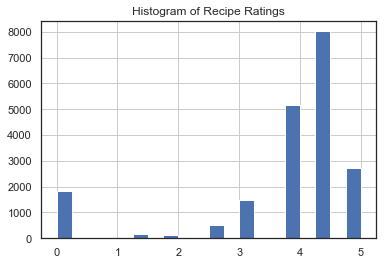

In [6]:
raw_data.rating.hist(bins=20)
plt.title('Histogram of Recipe Ratings')
plt.show()

In [7]:
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

In [9]:
svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
svr.fit(X,Y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

In [10]:
svr.score(X, Y)

-0.003978314483867873

In [12]:
cross_val_score(svr, X, Y, cv=5)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default 

array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

In [3]:
raw_data['grt_4stars'] = np.where(raw_data.rating >= 4, 1, 0)

raw_data.grt_4stars.value_counts()

1    10738
0     9314
Name: grt_4stars, dtype: int64

In [4]:
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium', 'grt_4stars'], 1)
Y = raw_data.grt_4stars

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=976)

print('Observations in training:', len(X_train))
print('Observations in test:', len(X_test))

Observations in training: 16041
Observations in test: 4011


In [5]:
sgdc = SGDClassifier(loss='log', penalty='l1', alpha=0.0002, fit_intercept=True)
sgdc.fit(X_train, Y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0002, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
sgdc.score(X_train, Y_train)

0.6110591609001933

In [43]:
cross_val_score(sgdc, X_train, Y_train, cv=5)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

array([0.59457775, 0.55811779, 0.57543641, 0.57574813, 0.56844403])

In [6]:
coef = sgdc.coef_
coef = coef.reshape((674,1))
print(len(X.columns))
print(len(coef))

674
674


In [7]:
feature_selection = pd.DataFrame()
feature_selection['features'] = X_train.columns
feature_selection['lasso_coef'] = coef

mask = (
    (feature_selection.lasso_coef > 0.5) |
    (feature_selection.lasso_coef < -0.3)
)
meaningful_features = feature_selection.loc[mask]

best_features = list(meaningful_features.features)

In [8]:
X = raw_data[best_features]
Y = raw_data.grt_4stars

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=976)

print('Observations in training:', len(X_train))
print('Observations in test:', len(X_test))

Observations in training: 16041
Observations in test: 4011


In [9]:
svc = SVC(kernel='linear')
svc.fit(X_train, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [14]:
Y_train_pred = svc.predict(X_train)
Y_test_pred = svc.predict(X_test)
print('Training Statistics\n')
print('r^2:', svc.score(X_train, Y_train))
print('\nConfusion_Matrix:\n', confusion_matrix(Y_train, Y_train_pred))
print('\n', classification_report(Y_train, Y_train_pred))

print('\n\nTest Statistics\n')
print('r^2:', svc.score(X_test, Y_test))
print('\nConfusion_Matrix:\n', confusion_matrix(Y_test, Y_test_pred))
print('\n', classification_report(Y_test, Y_test_pred))

Training Statistics

r^2: 0.577333083972321

Confusion_Matrix:
 [[1762 5687]
 [1093 7499]]

               precision    recall  f1-score   support

           0       0.62      0.24      0.34      7449
           1       0.57      0.87      0.69      8592

   micro avg       0.58      0.58      0.58     16041
   macro avg       0.59      0.55      0.52     16041
weighted avg       0.59      0.58      0.53     16041



Test Statistics

r^2: 0.5669409124906507

Confusion_Matrix:
 [[ 430 1435]
 [ 302 1844]]

               precision    recall  f1-score   support

           0       0.59      0.23      0.33      1865
           1       0.56      0.86      0.68      2146

   micro avg       0.57      0.57      0.57      4011
   macro avg       0.57      0.54      0.51      4011
weighted avg       0.57      0.57      0.52      4011



There was still some overfitting to the training set with the SVC model with fewer features when considering the r^2. The generalization gap was ~0.01. However, there is stability in the precision, recall, and f1 scores, which makes me feel a little better about the performance of the model.

The SVC with feature selection performed much better than the SVR with all of the features. Using an SGDClassifier with an l1 penalty may not be the best way to do feature selection for this problem, but it was computationally simple and was easily implemented. Another method to use would be evaluating all features against the binary classifier as single feature models to determine the most important features.

Going forward this model could use more hyperparameter tuning and a more detailed/deliberate feature selection process. The BayesSearchCV tuning script is written below, but was taking too long to run on my computer. 

In [ ]:
params = {
    'C':Real(1, 1e10, prior='uniform'),
    'kernel':Categorical(['linear', 'rbf', 'precomputed']),
    'shrinking':Categorical([True, False])
}
opt = BayesSearchCV (
    svc,
    params,
    cv=5,
    n_iter=5,
    random_state=345
)

opt.fit(X_train, Y_train)

In [ ]:
opt.score(X_train, Y_train)